In [1]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
%matplotlib inline

# define functions to run query faster
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
# return a list of all tables and views in our databases        
def show_tables():
    query='''
    SELECT name,type 
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(query)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Which Genre is popular in USA?

In [2]:
#returns each genre, with the number of tracks sold in the USA

q='''
WITH track_usa AS
    (
    SELECT invl.* 
    FROM customer c
    JOIN invoice inv
      ON c.customer_id=inv.customer_id
    JOIN invoice_line invl
      ON inv.invoice_id=invl.invoice_id
    WHERE c.country='USA'
    )
SELECT g.name genre,count(tusa.invoice_line_id) tracks_sold, 
       cast(count(tusa.invoice_line_id) as float)/(SELECT count(invoice_line_id) FROM track_usa)*100 percentage_sold
FROM genre g
JOIN track t
  ON g.genre_id=t.genre_id
JOIN track_usa tusa
  ON tusa.track_id=t.track_id
GROUP BY 1
ORDER BY 2 DESC

'''
run_query(q)

,genre,tracks_sold,percentage_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


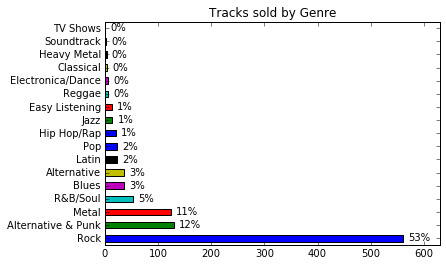

In [3]:
#plot
genre_usa=run_query(q)
genre_usa.set_index("genre",inplace=True)
genre_usa['tracks_sold'].plot.barh(title='Tracks sold by Genre',xlim=(0,630))
plt.xlabel('')
plt.ylabel("")

for i, index in enumerate(list(genre_usa.index)):
    score = genre_usa.loc[index, "tracks_sold"]
    label = (genre_usa.loc[index, "percentage_sold"]
            ).astype(int).astype(str) + "%"
    plt.annotate(label,(score+10 , i-0.2))

plt.show()

Based on the sales of tracks across different genres in the USA, the Rock is the most popular, followed by Punk and Metal



## The performance of sales support agent

In [4]:
q='''
SELECT e.first_name||' '||e.last_name name, hire_date,SUM(inv.total) total_sale
FROM employee e
JOIN customer c
  ON e.employee_id=c.support_rep_id
JOIN invoice inv
  ON c.customer_id=inv.customer_id
GROUP BY 1
ORDER BY 3 DESC

'''
run_query(q)

,name,hire_date,total_sale
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


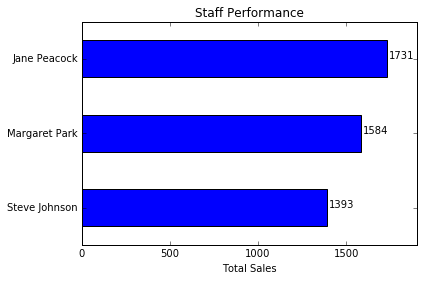

In [5]:
#plot
staff_performance=run_query(q)
staff_performance.set_index('name',inplace=True)
staff_performance.sort_values('total_sale',inplace=True)
staff_performance.plot.barh(title='Staff Performance',legend=False,xlim=(0,1900))
plt.xlabel('Total Sales')
plt.ylabel('')
for i, index in enumerate(list(staff_performance.index)):
    score = staff_performance.loc[index, "total_sale"]
    label = (staff_performance.loc[index, "total_sale"]
            ).astype(int).astype(str)
    plt.annotate(label,(score+10 , i))

plt.show()

While Jane sell the most and Steve the least, the reason could be Jane works six months longer than Steve.

## sales by country

In [6]:
sales_country='''
SELECT c.country,COUNT(DISTINCT c.customer_id) customers, SUM(i.total) total_sales,SUM(i.total)/COUNT(DISTINCT c.customer_id) average_per_customer,
       SUM(i.total)/COUNT(i.invoice_id) average_per_order,COUNT(i.invoice_id) num_order
FROM customer c
JOIN invoice i
  ON c.customer_id=i.customer_id
GROUP BY country
ORDER BY 2 DESC
'''
run_query(sales_country)
df_sales_country=run_query(sales_country)

df_sales_country



,country,customers,total_sales,average_per_customer,average_per_order,num_order
0,USA,13,1040.49,80.037692,7.942672,131
1,Canada,8,535.59,66.948750,7.047237,76
2,Brazil,5,427.68,85.536000,7.011148,61
3,France,5,389.07,77.814000,7.781400,50
4,Germany,4,334.62,83.655000,8.161463,41
5,United Kingdom,3,245.52,81.840000,8.768571,28
6,Czech Republic,2,273.24,136.620000,9.108000,30
7,India,2,183.15,91.575000,8.721429,21
8,Portugal,2,185.13,92.565000,6.383793,29
9,Argentina,1,39.60,39.600000,7.920000,5


In [7]:
#for better plot: put all country with only 1 customer into other
other=df_sales_country[df_sales_country['customers']==1]
other_row=pd.DataFrame({'country':['other'],
                     'customers':[other['customers'].sum()],
                     'total_sales':[other['total_sales'].sum()],
                     'average_per_customer':[np.mean(other['total_sales'])],
                     'average_per_order':[other['total_sales'].sum()/other['num_order'].sum()]})
df_sales_country=df_sales_country.append(other_row,ignore_index=True)
df_sales_country.drop(columns='num_order',inplace=True)

df_sales_country.set_index('country',inplace=True)
df_sales_country=df_sales_country[df_sales_country['customers']>1]
df_sales_country


,average_per_customer,average_per_order,customers,total_sales
country,,,,
USA,80.037692,7.942672,13,1040.49
Canada,66.948750,7.047237,8,535.59
Brazil,85.536000,7.011148,5,427.68
France,77.814000,7.781400,5,389.07
Germany,83.655000,8.161463,4,334.62
United Kingdom,81.840000,8.768571,3,245.52
Czech Republic,136.620000,9.108000,2,273.24
India,91.575000,8.721429,2,183.15
Portugal,92.565000,6.383793,2,185.13


## Visualizations to make recommendations on which countries may have potential for growth

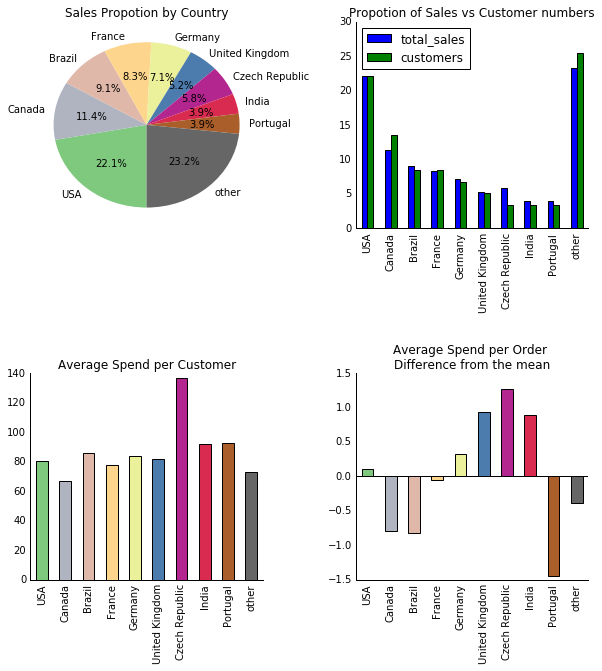

In [8]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=0.7,wspace=0.4)
#to make sure same country in each graph has the same color
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, df_sales_country.shape[0])]


#pie chart
df_sales_country['total_sales'].rename('').plot.pie(  #rename('') will remove the ylabel
    ax=ax[0][0],
    autopct='%1.1f%%',
    startangle=-90,
    counterclock=False,
    title='Sales Propotion by Country',
    colormap=plt.cm.Accent,
    fontsize=10,
    wedgeprops={'linewidth':0})

#bar chart for number of customer vs sales
cus_vs_cus=df_sales_country.copy()
cus_vs_cus.index.name = ''
cols=['total_sales','customers']
for col in cols:
    cus_vs_cus[col]=cus_vs_cus[col]/cus_vs_cus[col].sum()*100

cus_vs_cus[cols].plot.bar(
    ax=ax[0][1],
    title='Propotion of Sales vs Customer numbers')
ax[0][1].tick_params(top="off", right="off", left="off", bottom="off")
ax[0][1].spines["top"].set_visible(False)
ax[0][1].spines["right"].set_visible(False)

#bar chart show average spend per customer
avg_cus=df_sales_country['average_per_customer'].copy()
avg_cus.index.name=''

avg_cus.plot.bar(
    ax=ax[1][0],
    color=colors,
    title='Average Spend per Customer')
ax[1][0].tick_params(top="off", right="off", left="off", bottom="off")
ax[1][0].spines["top"].set_visible(False)
ax[1][0].spines["right"].set_visible(False)


#bar chart show average spend per order: difference to the mean
#difference with the mean will show results more clearly
difference=df_sales_country['average_per_order'].copy()
difference.index.name=''
differ=difference-difference.mean()
differ.plot.bar(
    ax=ax[1][1],
    color=colors,
    title='Average Spend per Order \nDifference from the mean')
ax[1][1].tick_params(top="off", right="off", left="off", bottom="off")
ax[1][1].spines["top"].set_visible(False)
ax[1][1].spines["right"].set_visible(False)
ax[1][1].axhline(0, color='k')




Based on the data, there may be opportunity in the following countries because of the high spend per order and per customer:

* Czech Republic
* United Kingdom
* India

Since the sample size is small,a better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Can we advise the manager to buy popular single tracks rather than the whole album from record companies to save money? 

In [9]:

#Query The number of tracks the customer bought each time when they 
#only bought one album; and the number of tacks in each albums
one_album_buyer='''

WITH 
invoice_album AS
    (
    SELECT invl.invoice_id , COUNT(invl.track_id) inv_track_num, t.album_id
    FROM invoice_line invl
    JOIN track t
      ON invl.track_id=t.track_id
    GROUP BY 1
    HAVING COUNT(DISTINCT t.album_id)=1
    ),

album_info AS
    (
    SELECT count(track_id) album_track_num,album_id 
    FROM track
    group by 2
    )

SELECT invoice_album.*, album_info.album_track_num
FROM invoice_album
JOIN album_info
  ON invoice_album.album_id=album_info.album_id
'''
df_one_album_buyer = run_query(one_album_buyer)
df_one_album_buyer.head(10)

,invoice_id,inv_track_num,album_id,album_track_num
0,1,16,91,16
1,5,17,163,17
2,13,1,206,12
3,14,1,42,14
4,23,10,1,10
5,24,12,90,12
6,31,20,221,20
7,32,13,6,13
8,34,1,49,10
9,44,12,242,12


In [10]:
# find the number of customers who bought the whole album each time
whole_album_buyer=df_one_album_buyer[df_one_album_buyer['inv_track_num']
                                     ==df_one_album_buyer['album_track_num']]

whole_album_buyer.shape[0]


114

There are at least 144 times when customers bought the whole album

In [11]:
#total number of salses records
q='''
SELECT count(DISTINCT invoice_id)
FROM invoice
'''
run_query(q)

,count(DISTINCT invoice_id)
0,614


In [12]:
print('The album purchase account for {:.2f}% of whole purchases'.format(114./614.*100))

The album purchase account for 18.57% of whole purchases


It should be noted that for the customer who bought the tracks across more than one album also could bought the whole album. Therefore, at least 18% purches are for whole album. We could not advise the manager to buy single tracks only since there is potential to lose one fifth of revenue.

## Which artist is the most popular one?

In [13]:
artists='''
SELECT ar.name artist,count(invl.track_id) num_track_sold
FROM artist ar
JOIN album
  ON ar.artist_id=album.artist_id
JOIN track t
  ON album.album_id=t.album_id
JOIN invoice_line invl
  ON t.track_id=invl.track_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
'''
run_query(artists)


,artist,num_track_sold
0,Queen,192
1,Jimi Hendrix,187
2,Nirvana,130
3,Red Hot Chili Peppers,130
4,Pearl Jam,129
5,AC/DC,124
6,Guns N' Roses,124
7,Foo Fighters,121
8,The Rolling Stones,117
9,Metallica,106


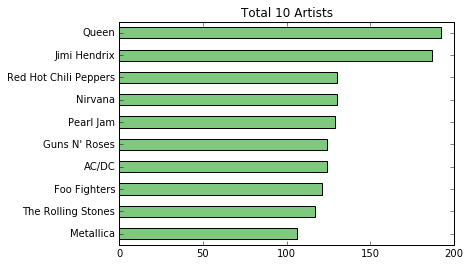

In [14]:
popular_artist=run_query(artists)
popular_artist.set_index('artist',inplace=True)
popular_artist.index.name=''
popular_artist.sort_values(by='num_track_sold').plot.barh(
    legend=False,
    colormap=plt.cm.Accent,
    title ='Total 10 Artists'
)

## How many tracks have been purchased vs not purchased?

In [15]:
track_sold='''
SELECT COUNT(DISTINCT invl.track_id) num
FROM invoice_line invl
JOIN track t
  ON invl.track_id=t.track_id
'''    
    
track_total='''
SELECT COUNT(DISTINCT track_id) num
FROM track
'''
print('There are about {:.2f}% tracks have not been sold.'
      .format(100*(1-run_query(track_sold)/ run_query(track_total)).iloc[0,0]))
                                                                  


There are about 48.44% tracks have not been sold.


To increase the sales, the manager need to buy the tracks based on the popularity of the genre and the artists

## Do protected vs non-protected media types have an effect on popularity?

In [16]:
q='SELECT * FROM media_type'
run_query(q)

,media_type_id,name
0,1,MPEG audio file
1,2,Protected AAC audio file
2,3,Protected MPEG-4 video file
3,4,Purchased AAC audio file
4,5,AAC audio file


In [17]:
media_type='''
WITH 
media_type_sold AS
    (SELECT m.name Media_Type, COUNT(invl.track_id) num_media_type_sold
      
    FROM media_type m
    JOIN track t
      ON m.media_type_id=t.media_type_id
    JOIN invoice_line invl
      ON t.track_id=invl.track_id
    GROUP BY 1),
media_type_stock AS
    (SELECT m.name Media_Type_stock, COUNT(t.track_id) num_media_type_stock
    FROM media_type m
    JOIN track t
      ON m.media_type_id=t.media_type_id
    GROUP BY 1)
    
SELECT * 
FROM media_type_sold
JOIN media_type_stock
  ON media_type_sold.Media_Type=media_type_stock.Media_Type_stock
        
'''
run_query(media_type)

,Media_Type,num_media_type_sold,Media_Type_stock,num_media_type_stock
0,AAC audio file,21,AAC audio file,11
1,MPEG audio file,4259,MPEG audio file,3034
2,Protected AAC audio file,439,Protected AAC audio file,237
3,Protected MPEG-4 video file,3,Protected MPEG-4 video file,214
4,Purchased AAC audio file,35,Purchased AAC audio file,7


In [18]:
df_media_type=run_query(media_type)
df_media_type=df_media_type.drop(columns='Media_Type_stock')
df_media_type.set_index('Media_Type',inplace=True)
df_media_type.index.name=''
df_media_type

,num_media_type_sold,num_media_type_stock
,,
AAC audio file,21,11
MPEG audio file,4259,3034
Protected AAC audio file,439,237
Protected MPEG-4 video file,3,214
Purchased AAC audio file,35,7


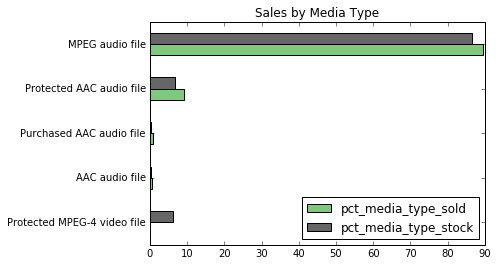

In [19]:
col=['num_media_type_sold','num_media_type_stock']
for item in col:
    df_media_type[item]=100*df_media_type[item]/df_media_type[item].sum()


df_media_type.sort_values('num_media_type_sold').plot.barh(
    title='Sales by Media Type',
#    legend=False,
    colormap=plt.cm.Accent
    )    

L=plt.legend(loc='lower right')
L.get_texts()[0].set_text('pct_media_type_sold')
L.get_texts()[1].set_text('pct_media_type_stock')


It is clear that the propotion of the sold media type is inline with the one in stock except the "protected MP4 Video". It may reflect the customers prefer audio rather than video. 

In [20]:
genre_num_media='''
SELECT m.name Media_Type, COUNT(DISTINCT g.name) Num_Genre, AVG(t.unit_price)
FROM genre g
JOIN track t
  ON g.genre_id=t.genre_id
JOIN media_type m
  ON t.media_type_id=m.media_type_id
GROUP BY 1
ORDER BY 3 DESC
'''
run_query(genre_num_media)

,Media_Type,Num_Genre,AVG(t.unit_price)
0,Protected MPEG-4 video file,6,1.985327
1,Protected AAC audio file,7,0.990000
2,AAC audio file,6,0.990000
3,Purchased AAC audio file,2,0.990000
4,MPEG audio file,17,0.990000
